In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

/Users/omrishlezinger/Documents/biological ML and statistics/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def load_data(train_path, test_path):
    print(f"Loading data from: {train_path} and {test_path}...")
    
    # טעינת קבצי הפרקט
    df_train = pd.read_parquet(train_path)
    df_test = pd.read_parquet(test_path)
    
    # הנחה: העמודות בקובץ נקראות 'seq' (הרצף) ו-'label' (התיוג)
    # אם השמות אצלך שונים, יש לשנות את המחרוזות בסוגריים
    X_train = df_train['seq'].astype(str).tolist()
    y_train = df_train['label'].values
    
    X_test = df_test['seq'].astype(str).tolist()
    y_test = df_test['label'].values
    
    print(f"Data loaded successfully.")
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    return X_train, y_train, X_test, y_test

# נתיבי הקבצים (החלף בנתיב האמיתי שלך אם צריך)
X_train_raw, y_train, X_test_raw, y_test = load_data('./data/train.parquet', './data/test.parquet')


Loading data from: ./data/train.parquet and ./data/test.parquet...
Data loaded successfully.
Train samples: 20843, Test samples: 6948


In [3]:
# ==========================================
# 2. קידוד K-mer עבור SVM
# ==========================================
# פונקציה שממירה רצפי DNA לוקטורים של ספירת K-mers
# לדוגמה, אם K=3, הרצף "ACGT" יהפוך לספירות של: ACG, CGT וכו'
def kmer_encoding(X_train, X_test, k=4):
    print(f"\nEncoding sequences using {k}-mers...")
    
    # analyzer='char' מתייחס למחרוזת כרצף תווים
    # ngram_range=(k, k) מבטיח שנקבל רק רצפים באורך k בדיוק
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    
    # לומדים את ה-Vocabulary מסט האימון וממירים
    X_train_kmer = vectorizer.fit_transform(X_train)
    
    # ממירים את סט המבחן לפי אותו Vocabulary
    X_test_kmer = vectorizer.transform(X_test)
    
    print(f"Vectorization complete. Number of features ({k}-mers found): {len(vectorizer.get_feature_names_out())}")
    return X_train_kmer, X_test_kmer, vectorizer

# ביצוע הקידוד (נשתמש ב-K=4, שזה סטנדרט טוב לביואינפורמטיקה)
X_train_svm, X_test_svm, vocab = kmer_encoding(X_train_raw, X_test_raw, k=4)

# ==========================================
# 3. אימון ו-ואלידציה באמצעות SVM
# ==========================================
print("\n--- Training SVM Classifier ---")

# הגדרת המודל
# C=1.0 הוא פרמטר רגולריזציה סטנדרטי
# kernel='rbf' בדרך כלל נותן ביצועים טובים יותר מליניארי לדאטה גנומי
svm_clf = SVC(kernel='rbf', C=1.0, random_state=42)

# אימון
svm_clf.fit(X_train_svm, y_train)

# חיזוי
y_pred = svm_clf.predict(X_test_svm)

# דוח תוצאות
print("\n--- SVM Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Encoding sequences using 4-mers...
Vectorization complete. Number of features (4-mers found): 256

--- Training SVM Classifier ---

--- SVM Results ---
Accuracy: 0.7399

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3474
           1       0.74      0.74      0.74      3474

    accuracy                           0.74      6948
   macro avg       0.74      0.74      0.74      6948
weighted avg       0.74      0.74      0.74      6948

Confusion Matrix:
[[2571  903]
 [ 904 2570]]


In [ ]:
print("\n--- Preparing for Neural Network ---")

# מיפוי בסיסים למספרים
dna_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4} # N למקרה של חוסר ודאות

def one_hot_encode_sequences(sequences, max_len=500):
    # נניח שאורך הרצפים בדאטה הזה הוא 500 (הסטנדרט ב-cohn)
    # אם האורכים משתנים, צריך לעשות Padding
    X = np.zeros((len(sequences), max_len, 4), dtype=np.float32)
    
    for i, seq in enumerate(sequences):
        for j, char in enumerate(seq):
            if j >= max_len: break
            if char in dna_map and dna_map[char] < 4:
                X[i, j, dna_map[char]] = 1.0
    return X

# בדיקת האורך המקסימלי בדאטה (במקרה הזה הוא קבוע, אבל ליתר ביטחון)
max_seq_len = 500 
X_train_nn = one_hot_encode_sequences(X_train_raw, max_len=max_seq_len)
X_test_nn = one_hot_encode_sequences(X_test_raw, max_len=max_seq_len)

# בניית המודל
model = Sequential([
    # שכבת קונבולוציה ראשונה - חיפוש מוטיבים
    Conv1D(filters=64, kernel_size=12, activation='relu', input_shape=(max_seq_len, 4)),
    MaxPooling1D(pool_size=4),
    Dropout(0.2), # למניעת Overfitting
    
    # שכבה שנייה - חיפוש קומבינציות של מוטיבים
    Conv1D(filters=32, kernel_size=6, activation='relu'),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),
    
    # שיטוח והחלטה
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # פלט בינארי (0 או 1)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


--- Preparing for Neural Network ---


/Users/omrishlezinger/Documents/biological ML and statistics/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 489, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 122, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 117, 32)        │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        59,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,977 (292.88 KB)

 Trainable params: 74,977 (292.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6506 - loss: 0.6165 - val_accuracy: 0.6713 - val_loss: 0.5984
Epoch 2/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6780 - loss: 0.5956 - val_accuracy: 0.6805 - val_loss: 0.5876
Epoch 3/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6918 - loss: 0.5806 - val_accuracy: 0.6939 - val_loss: 0.5808
Epoch 4/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7003 - loss: 0.5678 - val_accuracy: 0.7111 - val_loss: 0.5608
Epoch 5/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7130 - loss: 0.5561 - val_accuracy: 0.6887 - val_loss: 0.5810
Epoch 6/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7208 - loss: 0.5429 - val_accuracy: 0.7147 - val_loss: 0.5549
Epoch 7/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7325 - loss: 0.5309 - val_accuracy: 0.7150 - val_loss: 0.5577
Epoch 8/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7358 - loss: 0.5227 - val_accuracy: 0.

In [ ]:
# אימון עם Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_nn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_nn, y_test),
    callbacks=[early_stop]
)

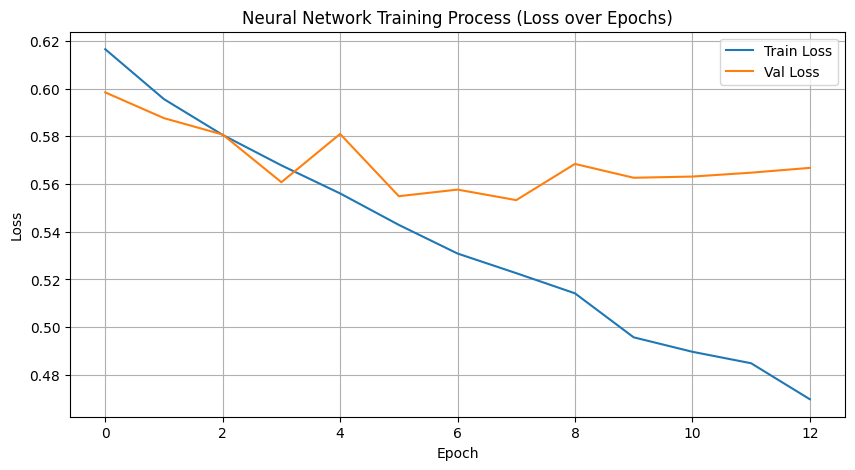


============= Final Comparison =============
SVM Accuracy (K-mers):   0.7399
CNN Accuracy (One-Hot):  0.7150
Result: Classical ML (SVM) performed better (or similar).


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ==========================================
# 5. השוואה וניתוח תוצאות
# ==========================================

# גרף Loss של רשת הנוירונים
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Training Process (Loss over Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# הערכה סופית לרשת הנוירונים (CNN)
# verbose=0 משתיק את סרגל ההתקדמות כדי שהפלט יהיה נקי
nn_loss, nn_acc = model.evaluate(X_test_nn, y_test, verbose=0)

# חישוב דיוק ה-SVM מחדש (או שימוש במשתנה שמור) לשם ההשוואה
# y_pred הוא המשתנה שיצרנו בשלב ה-SVM בקוד הקודם
svm_acc = accuracy_score(y_test, y_pred)

print(f"\n============= Final Comparison =============")
print(f"SVM Accuracy (K-mers):   {svm_acc:.4f}")
print(f"CNN Accuracy (One-Hot):  {nn_acc:.4f}")
print(f"============================================")

if nn_acc > svm_acc:
    print("Result: Deep Learning (CNN) performed better.")
else:
    print("Result: Classical ML (SVM) performed better (or similar).")